In [2]:
import pickle
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import  Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from keras.applications import MobileNetV2, DenseNet121, DenseNet201

# To chain two different data augmented images for training
#from itertools import chain

#  Distributed Computing
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )
print('Data Augmentation 2 was created')

Data Augmentation 1 was created
Data Augmentation 2 was created


In [4]:
data_generator_3 = ImageDataGenerator(rescale=1./255)

train_generator1 = data_generator_1.flow_from_directory(
    directory=r"Train",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print('Data Augmentation 1 was used to generate the train data set\n')

test_generator = data_generator_3.flow_from_directory(
    directory=r"Test",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 5712 images belonging to 4 classes.
Data Augmentation 1 was used to generate the train data set

Found 1311 images belonging to 4 classes.


In [5]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


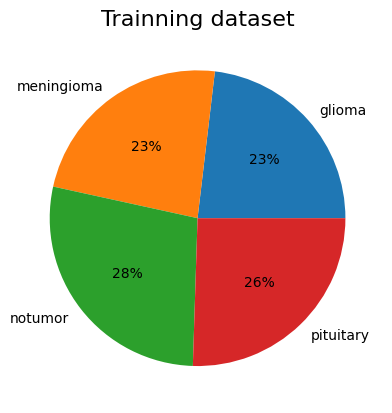

In [6]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [7]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of bacterial pneumonia images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 1]))
print("Number of viral pneumonia images:", len([label for label in train_generator1.classes if label == 2]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of bacterial pneumonia images:", len([label for label in test_generator.classes if label == 0]))
print("Number of normal images:", len([label for label in test_generator.classes if label == 1]))
print("Number of viral pneumonia images:", len([label for label in test_generator.classes if label == 2]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 5712
Number of bacterial pneumonia images: 1321
Number of normal images: 1339
Number of viral pneumonia images: 1595

Dataset Characteristics of Test Data Set:
Number of images: 1311
Number of bacterial pneumonia images: 300
Number of normal images: 306
Number of viral pneumonia images: 405



In [8]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 1.080999242997729,
 1: 1.0664675130694548,
 2: 0.8952978056426333,
 3: 0.9800960878517502}

Train image data from Data Augmentation 1


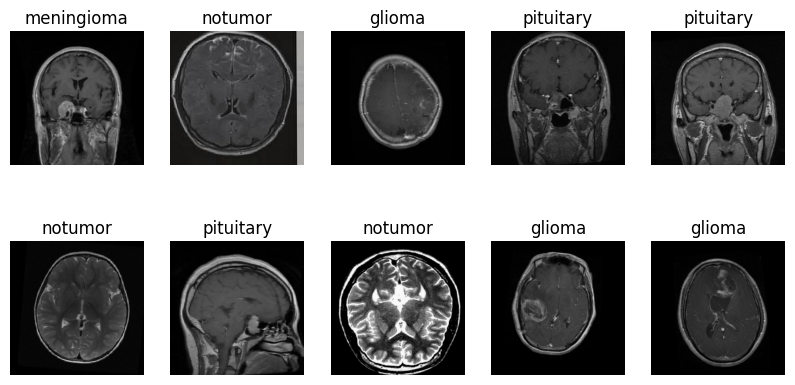

In [9]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()

In [10]:
# Define the epochs for training
EPOCHS = 15

# Define the number of GPUs to use
num_gpus = 2

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

train_data = train_generator1

In [12]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained MobileNetV2 model without the top classification layer
    base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_MobileNet.layers:
        layer.trainable = False

    # Create a new model and add the MobileNetV2 base model
    model_MobileNet = Sequential()
    model_MobileNet.add(base_model_MobileNet)

    # Add a global average pooling layer and output layer for classification
    model_MobileNet.add(GlobalAveragePooling2D())
    model_MobileNet.add(Dense(128, activation='relu'))
    model_MobileNet.add(Dropout(0.4))
    model_MobileNet.add(Dense(64, activation='relu'))
    model_MobileNet.add(Dropout(0.2))
    model_MobileNet.add(Dense(4, activation='softmax'))

    # Model summary
    print("Model Summary (MobileNetV2):")
    model_MobileNet.summary()
    print()

    # Compile the model
    model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_MobileNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


9406464/9406464 [==============================] - 3s 0us/step
Model Summary (MobileNetV2):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                          

In [13]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained DenseNet121 model without the top classification layer
    base_model_DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_DenseNet121.layers:
        layer.trainable = False

    # Create a new model and add the DenseNet121 base model
    model_DenseNet121 = Sequential()
    model_DenseNet121.add(base_model_DenseNet121)

    # Add a global average pooling layer and output layer for classification
    model_DenseNet121.add(GlobalAveragePooling2D())
    model_DenseNet121.add(Dense(128, activation='relu'))
    model_DenseNet121.add(Dropout(0.4))
    model_DenseNet121.add(Dense(64, activation='relu'))
    model_DenseNet121.add(Dropout(0.2))
    model_DenseNet121.add(Dense(4, activation='softmax'))

    # Model summary
    print("Model Summary (DenseNet121):")
    model_DenseNet121.summary()
    print()

    # Compile the model
    model_DenseNet121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_DenseNet = model_DenseNet121.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_DenseNet121, val_accuracy_DenseNet121 = model_DenseNet121.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_DenseNet121:.4f}')
    print(f'Validation Accuracy: {val_accuracy_DenseNet121:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
29084464/29084464 [==============================] - 8s 0us/step
Model Summary (DenseNet121):
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8

In [ ]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained DenseNet121 model without the top classification layer
    base_model_DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_DenseNet201.layers:
        layer.trainable = False

    # Create a new model and add the DenseNet121 base model
    model_DenseNet201 = Sequential()
    model_DenseNet201.add(base_model_DenseNet201)

    # Add a global average pooling layer and output layer for classification
    model_DenseNet201.add(GlobalAveragePooling2D())
    model_DenseNet201.add(Dense(128, activation='relu'))
    model_DenseNet201.add(Dropout(0.4))
    model_DenseNet201.add(Dense(64, activation='relu'))
    model_DenseNet201.add(Dropout(0.2))
    model_DenseNet201.add(Dense(4, activation='softmax'))

    # Model summary
    print("Model Summary (DenseNet201):")
    model_DenseNet201.summary()
    print()

    # Compile the model
    model_DenseNet201.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_DenseNet201 = model_DenseNet201.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_DenseNet201, val_accuracy_DenseNet201 = model_DenseNet201.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_DenseNet201:.4f}')
    print(f'Validation Accuracy: {val_accuracy_DenseNet201:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (InceptionV3):
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                       

In [ ]:
data = {
    'MobileNet': val_accuracy_MobileNet,
    'DenseNet121': val_accuracy_DenseNet121,
    'DenseNet201': val_accuracy_DenseNet201
}

In [ ]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

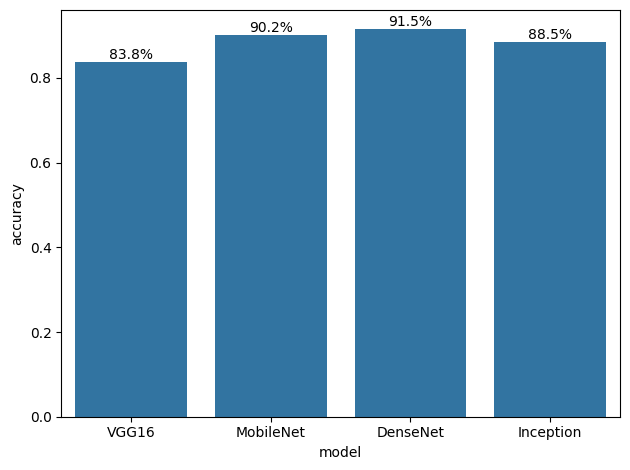

In [ ]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

In [ ]:
# Fine-tune the model with frozen layers

# Unfreeze the base_model
no_base_layers = len(model_DenseNet.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/2)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

No. of base layers in the model = 7

No. of layers for fine-tune = 3


In [ ]:
for layer in model_DenseNet.layers:
    print("Layer Name:", layer.name)
    print("Layer Type:", type(layer).__name__)
    print("Input Shape:", layer.input_shape)
    print("Output Shape:", layer.output_shape)
    print("Trainable:", layer.trainable)
    print("===================")


Layer Name: densenet121
Layer Type: Functional
Input Shape: (None, 299, 299, 3)
Output Shape: (None, 9, 9, 1024)
Trainable: True
Layer Name: global_average_pooling2d_3
Layer Type: GlobalAveragePooling2D
Input Shape: (None, 9, 9, 1024)
Output Shape: (None, 1024)
Trainable: True
Layer Name: dense_9
Layer Type: Dense
Input Shape: (None, 1024)
Output Shape: (None, 128)
Trainable: True
Layer Name: dropout_6
Layer Type: Dropout
Input Shape: (None, 128)
Output Shape: (None, 128)
Trainable: True
Layer Name: dense_10
Layer Type: Dense
Input Shape: (None, 128)
Output Shape: (None, 64)
Trainable: True
Layer Name: dropout_7
Layer Type: Dropout
Input Shape: (None, 64)
Output Shape: (None, 64)
Trainable: True
Layer Name: dense_11
Layer Type: Dense
Input Shape: (None, 64)
Output Shape: (None, 4)
Trainable: True


In [ ]:
# Fine-tune the model
model_DenseNet.trainable = True
for layer in model_DenseNet.layers[: -no_finetune_layers]:
    layer.trainable = False

# small learning rate for fine tuning
model_DenseNet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune_MobileNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/15
119/119 [==============================] - 484s 4s/step - loss: 0.2095 - accuracy: 0.9245 - val_loss: 0.2256 - val_accuracy: 0.9161
Epoch 2/15
119/119 [==============================] - 477s 4s/step - loss: 0.2102 - accuracy: 0.9240 - val_loss: 0.2264 - val_accuracy: 0.9153
Epoch 3/15
119/119 [==============================] - 477s 4s/step - loss: 0.2101 - accuracy: 0.9247 - val_loss: 0.2271 - val_accuracy: 0.9153
Epoch 3: early stopping


In [ ]:
# Validate the model
print('====== Model Validation ======')
val_loss_finetune_DenseNet, val_accuracy_finetune_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_finetune_DenseNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_finetune_DenseNet:.4f}')

====== Model Validation ======
28/28 [==============================] - 88s 3s/step - loss: 0.2256 - accuracy: 0.9161
Validation Loss: 0.2256
Validation Accuracy: 0.9161


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
DenseNet_test_preds = model_DenseNet.predict(test_generator)
DenseNet_test_pred_classes = np.argmax(DenseNet_test_preds, axis=1)

28/28 [==============================] - 90s 3s/step


2/2 [==============================] - 5s 1s/step


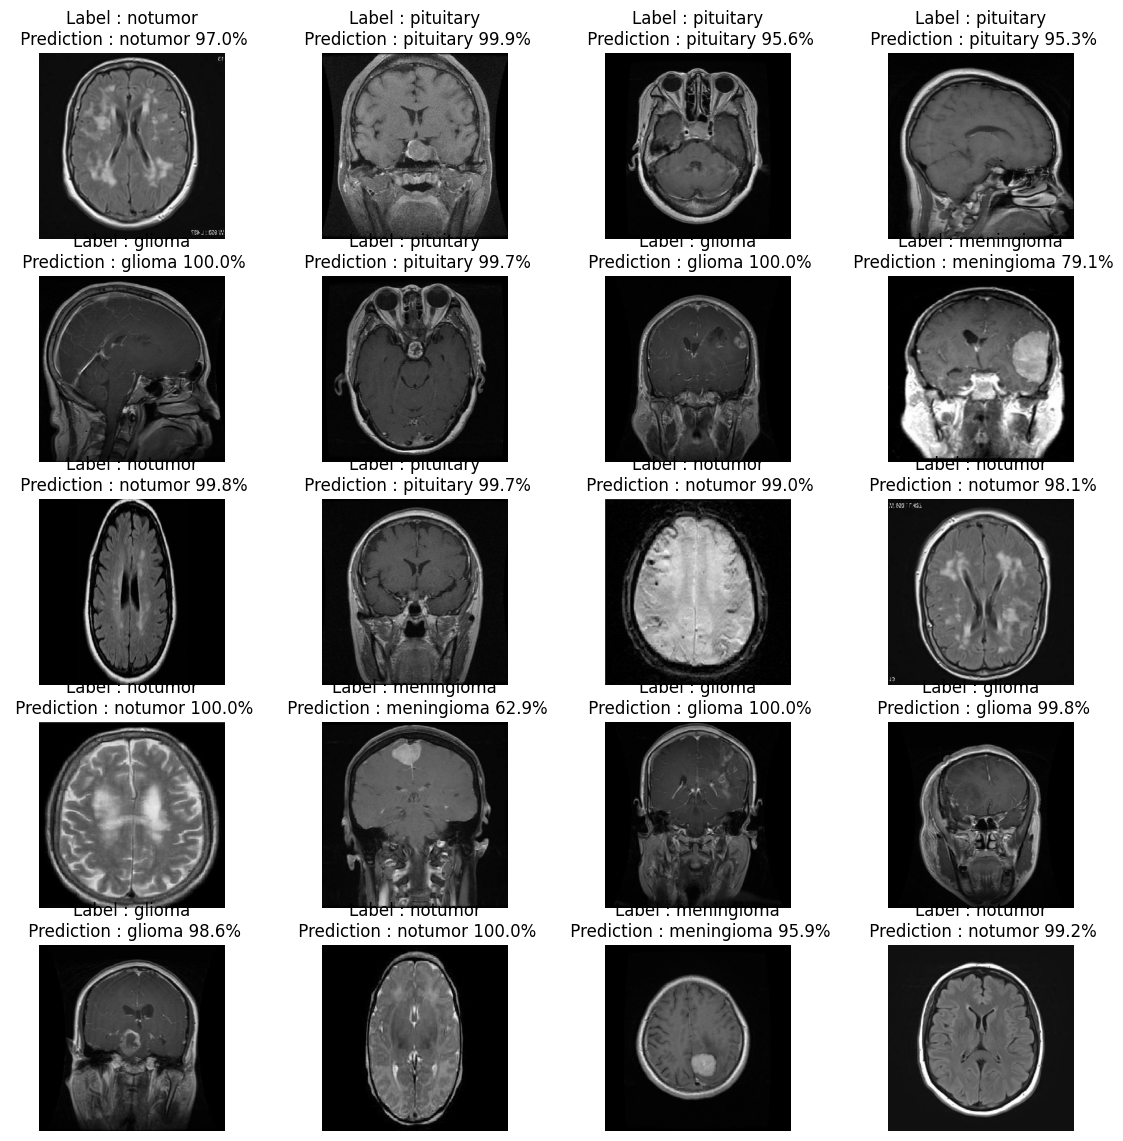

In [ ]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_DenseNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [ ]:
test_dir = r"Test"

# Image dimensions
image_height = 299
image_width = 299

# Create ImageDataGenerator for test data
test_data_generator = ImageDataGenerator(rescale=1./255)

# Load test data using the generator
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=1,
    shuffle=False,  # Important: Set shuffle to False to maintain order
    class_mode='categorical'
)

# Get predictions and true labels
y_pred = model_DenseNet.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
file_names = test_generator.filenames

# Identify mispredicted indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Print file names of mispredicted images
print("\nMispredicted File Names:")
for idx in misclassified_indices:
    print(file_names[idx])

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Classification Report
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Display Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display Classification Report
print("\nClassification Report:")
print(class_report)

Found 1311 images belonging to 4 classes.
1311/1311 [==============================] - 93s 71ms/step

Mispredicted File Names:
glioma\Te-gl_0030.jpg
glioma\Te-gl_0043.jpg
glioma\Te-gl_0045.jpg
glioma\Te-gl_0046.jpg
glioma\Te-gl_0047.jpg
glioma\Te-gl_0048.jpg
glioma\Te-gl_0094.jpg
glioma\Te-gl_0099.jpg
glioma\Te-gl_0107.jpg
glioma\Te-gl_0159.jpg
glioma\Te-gl_0206.jpg
glioma\Te-gl_0229.jpg
glioma\Te-gl_0233.jpg
glioma\Te-gl_0234.jpg
glioma\Te-gl_0235.jpg
glioma\Te-gl_0236.jpg
glioma\Te-gl_0237.jpg
glioma\Te-gl_0239.jpg
glioma\Te-gl_0240.jpg
glioma\Te-gl_0241.jpg
glioma\Te-gl_0242.jpg
glioma\Te-gl_0246.jpg
glioma\Te-gl_0247.jpg
glioma\Te-gl_0249.jpg
glioma\Te-gl_0258.jpg
glioma\Te-gl_0259.jpg
glioma\Te-gl_0260.jpg
glioma\Te-gl_0261.jpg
glioma\Te-gl_0262.jpg
glioma\Te-gl_0263.jpg
glioma\Te-gl_0264.jpg
glioma\Te-gl_0265.jpg
glioma\Te-gl_0266.jpg
glioma\Te-gl_0267.jpg
glioma\Te-gl_0268.jpg
glioma\Te-gl_0270.jpg
glioma\Te-gl_0271.jpg
glioma\Te-gl_0272.jpg
glioma\Te-gl_0273.jpg
glioma\Te-gl_02

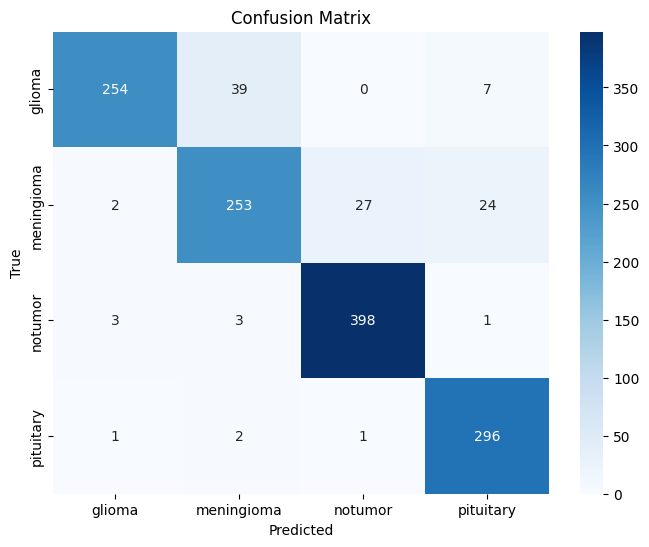

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.85      0.91       300
  meningioma       0.85      0.83      0.84       306
     notumor       0.93      0.98      0.96       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



In [ ]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print('Classification Report:')
print(class_report)

In [ ]:
model_MobileNet.save("DenseNet-model.h5")